In [2]:
import numpy as np
import pymc3 as pm
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

palette = 'muted'
sns.set_palette(palette)
sns.set_color_codes(palette)

np.set_printoptions(precision=2)

pd.set_option('display.precision', 2)


WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


(1000,) (1000,)


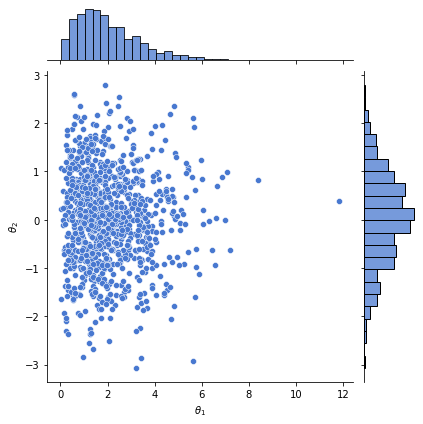

In [3]:
np.random.seed(123)

x = np.random.gamma(2, 1, 1000)
y = np.random.normal(0, 1, 1000)
# y = np.random.beta(0.25, 0.5, 1000)
# y = np.random.binomial(1000, 0.5, 1000)
print(x.shape, y.shape)
data = pd.DataFrame(data=np.array([x, y]).T, columns=[
                    '$\\theta_1$', '$\\theta_2$'])

sns.jointplot(x='$\\theta_1$', y='$\\theta_2$', data=data)


In [4]:
# Gaussian inferences

data = np.array([51.06, 55.12, 53.73, 50.24, 52.05, 56.40, 48.45, 52.34, 55.65, 51.49, 51.86, 63.43, 53.00, 56.09, 51.93, 52.31, 52.33, 57.48, 57.44, 55.14, 53.93, 54.62, 56.09,
                68.58, 51.36, 55.47, 50.73, 51.94, 54.95, 50.39, 52.91, 51.5, 52.68, 47.72, 49.73, 51.82, 54.99, 52.84, 53.19, 54.52, 51.46, 53.73, 51.61, 49.81, 52.42, 54.3, 53.84, 53.16])


# remove outliers using the interquartile rule
quant = np.percentile(data, [25, 75])
iqr = quant[1] - quant[0]
upper_b = quant[1] + iqr * 1.5
lower_b = quant[0] - iqr * 1.5
clean_data = data[(data > lower_b) & (data < upper_b)]
print(quant, iqr, upper_b, lower_b)
# print(len(clean_data), len(data))
# print(np.mean(data), np.std(data))
# print(np.mean(clean_data), np.std(clean_data))


[51.58 54.96] 3.377500000000005 60.026250000000005 46.516249999999985


Text(0.5, 0, '$x$')

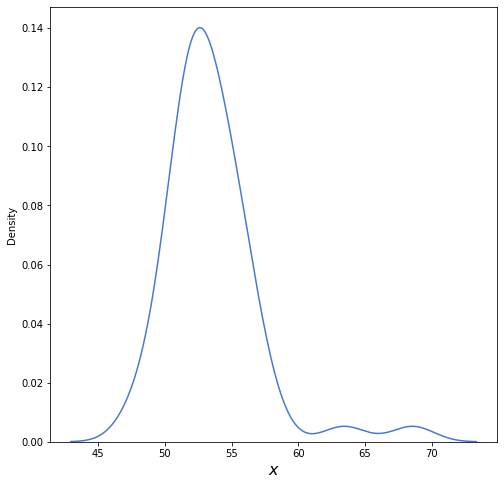

In [5]:
plt.figure(figsize=(8, 8))
sns.kdeplot(data)
plt.xlabel('$x$', fontsize=16)

In [6]:
with pm.Model() as model_g:
    # ------------ Old code ------------
    mu = pm.Uniform('mu', lower=40, upper=70)
    sigma = pm.HalfNormal('sigma', sd=10)
    y = pm.Normal('y', mu=mu, sd=sigma, observed=data)

    # mu = pm.Uniform('mu', lower=lower_b, upper=upper_b)
    # sigma = pm.HalfNormal('sigma', sd=np.std(clean_data))
    # y = pm.Normal('y', mu=mu, sd=sigma, observed=clean_data)
    
    trace_g = pm.sampling.sample(1000, return_inferencedata=False)   # 1100

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, mu]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 19 seconds.


Got error No model on context stack. trying to find log_likelihood in translation.
e:\Code\Algorithmic-Trading\env\lib\site-packages\arviz\data\io_pymc3_3x.py:102: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
Got error No model on context stack. trying to find log_likelihood in translation.


array([[<AxesSubplot:title={'center':'mu'}>,
        <AxesSubplot:title={'center':'mu'}>],
       [<AxesSubplot:title={'center':'sigma'}>,
        <AxesSubplot:title={'center':'sigma'}>]], dtype=object)

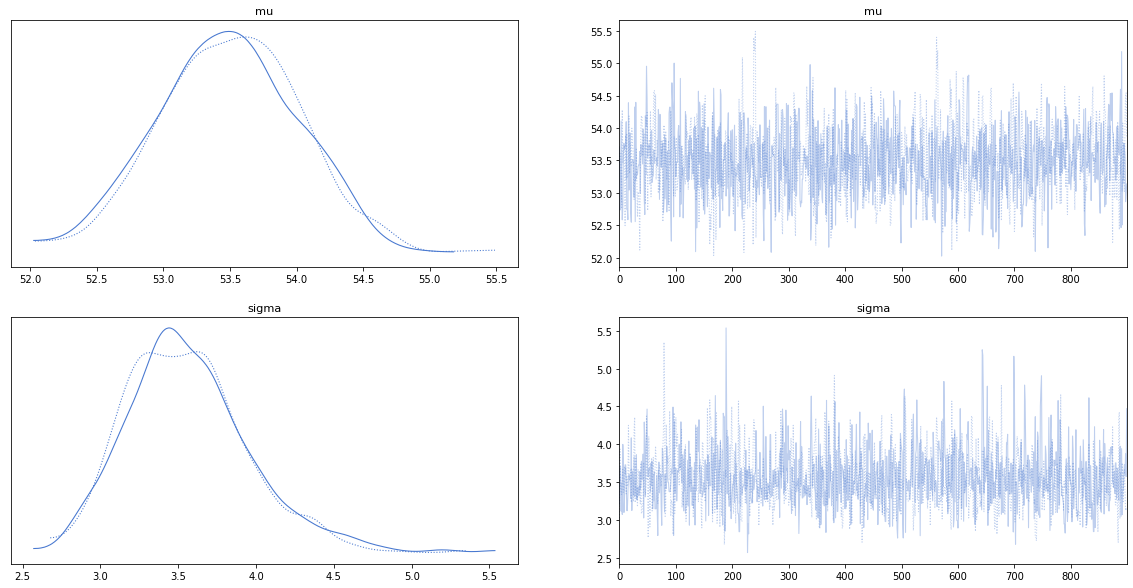

In [7]:
chain_g = trace_g[100:]
pm.plot_trace(chain_g, figsize=(20, 10))

In [8]:
pm.summary(chain_g)

Got error No model on context stack. trying to find log_likelihood in translation.
e:\Code\Algorithmic-Trading\env\lib\site-packages\arviz\data\io_pymc3_3x.py:102: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,53.50,0.54,52.45,54.46,0.01,1.00e-02,1481.0,1152.0,1.0
sigma,3.56,0.39,2.88,4.33,0.01,8.00e-03,1441.0,1205.0,1.0


e:\Code\Algorithmic-Trading\env\lib\site-packages\pymc3\sampling.py:1690: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "


Text(0.5, 0, '$x$')

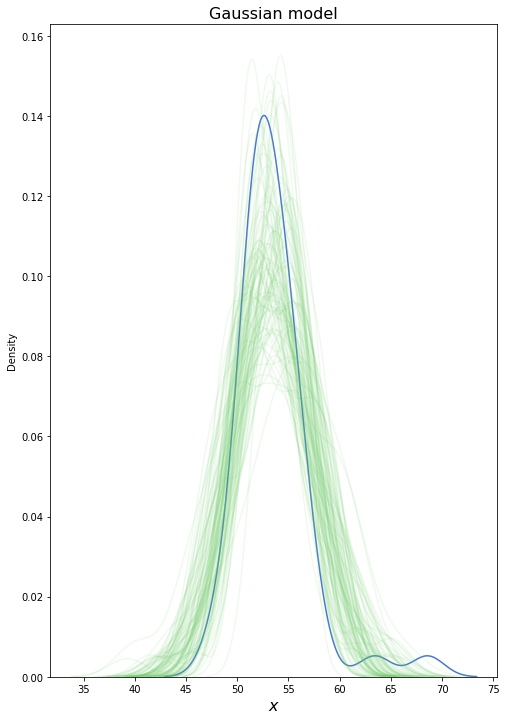

In [9]:
# computed from each one of the 100 posterior predictive samples
y_pred = pm.sampling.sample_posterior_predictive(chain_g, 100, model_g, size=len(data))
# y_pred = pm.sampling.sample_posterior_predictive(chain_g, 100, model_g, size=len(clean_data))
plt.figure(figsize=(8, 12))

sns.kdeplot(data, color='b')
# sns.kdeplot(clean_data, color='b')

for i in y_pred['y']:
    dataset = pd.DataFrame({'Column1': i[:, 0], 'Column2': i[:, 1]})
    # sns.kdeplot(dataset.Column1, color='r', alpha=0.1)
    sns.kdeplot(dataset.Column2, color='g', alpha=0.1)

plt.title('Gaussian model', fontsize=16)
plt.xlabel('$x$', fontsize=16)

(-7.0, 7.0)

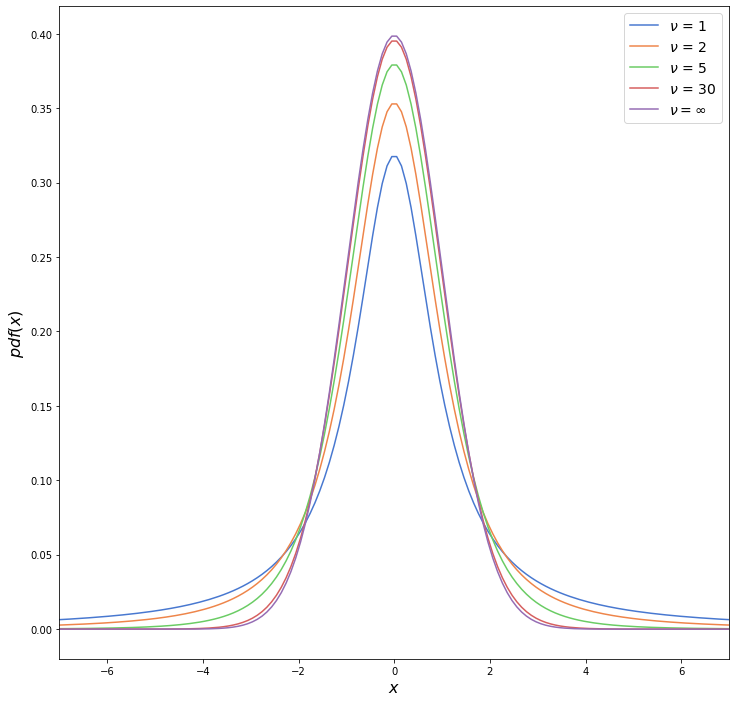

In [10]:
# Student's t-distribution

x_values = np.linspace(-10, 10, 200)
plt.figure(figsize=(12, 12))

# for df in [0.15, 1, 2, 4]:
for df in [1, 2, 5, 30]:
    distri = stats.t(df)
    x_pdf = distri.pdf(x_values)
    plt.plot(x_values, x_pdf, label=r'$\nu$ = {}'.format(df))

# infinity case
x_pdf = stats.norm.pdf(x_values)
plt.plot(x_values, x_pdf, label=r'$\nu = \infty$')

plt.xlabel('$x$', fontsize=16)
plt.ylabel('$pdf(x)$', fontsize=16, rotation=90)
plt.legend(loc=0, fontsize=14)
plt.xlim(-7, 7)


In [11]:
with pm.Model() as model_t:
    mu = pm.Uniform('mu', 40, 75)
    sigma = pm.HalfNormal('sigma', sd=10)
    nu = pm.Exponential('nu', 1/30)
    
    y = pm.StudentT('y', mu=mu, sd=sigma, nu=nu, observed=data)
    trace_t = pm.sampling.sample(1000, return_inferencedata=False)   # 1100

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, sigma, mu]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 19 seconds.


Got error No model on context stack. trying to find log_likelihood in translation.
e:\Code\Algorithmic-Trading\env\lib\site-packages\arviz\data\io_pymc3_3x.py:102: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
Got error No model on context stack. trying to find log_likelihood in translation.


array([[<AxesSubplot:title={'center':'mu'}>,
        <AxesSubplot:title={'center':'mu'}>],
       [<AxesSubplot:title={'center':'sigma'}>,
        <AxesSubplot:title={'center':'sigma'}>],
       [<AxesSubplot:title={'center':'nu'}>,
        <AxesSubplot:title={'center':'nu'}>]], dtype=object)

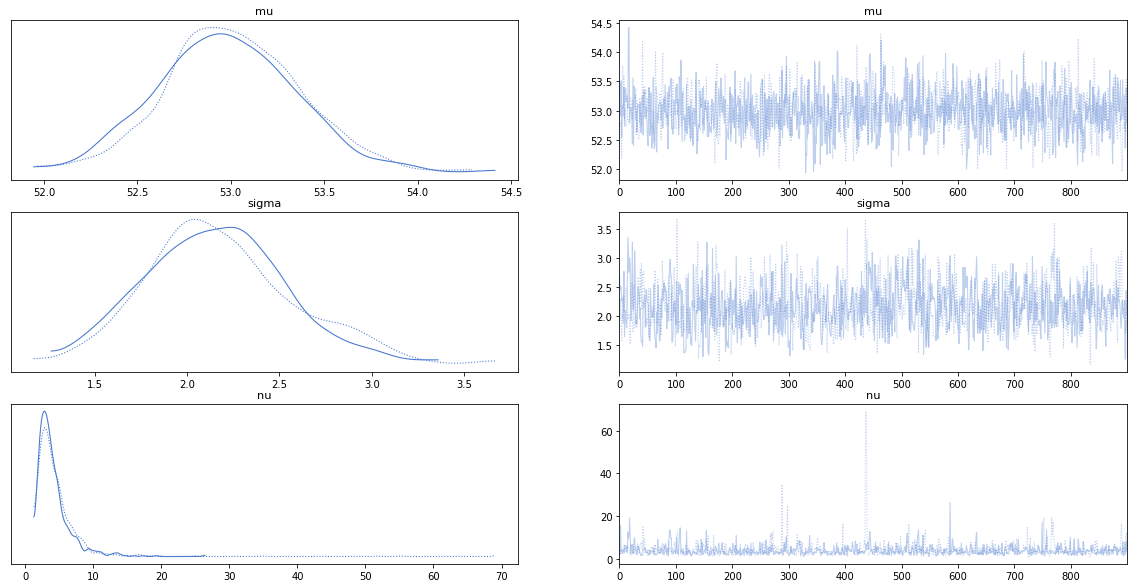

In [12]:
chain_t = trace_t[100:]
pm.plot_trace(chain_t, figsize=(20, 10))

In [13]:
pm.summary(chain_t)

Got error No model on context stack. trying to find log_likelihood in translation.
e:\Code\Algorithmic-Trading\env\lib\site-packages\arviz\data\io_pymc3_3x.py:102: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,53.00,0.37,52.24,53.63,0.01,7.00e-03,1227.0,1099.0,1.0
sigma,2.17,0.39,1.46,2.92,0.01,9.00e-03,901.0,812.0,1.0
nu,4.35,3.43,1.22,8.29,0.13,9.50e-02,964.0,878.0,1.0


e:\Code\Algorithmic-Trading\env\lib\site-packages\pymc3\sampling.py:1690: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "


Text(0.5, 0, '$x$')

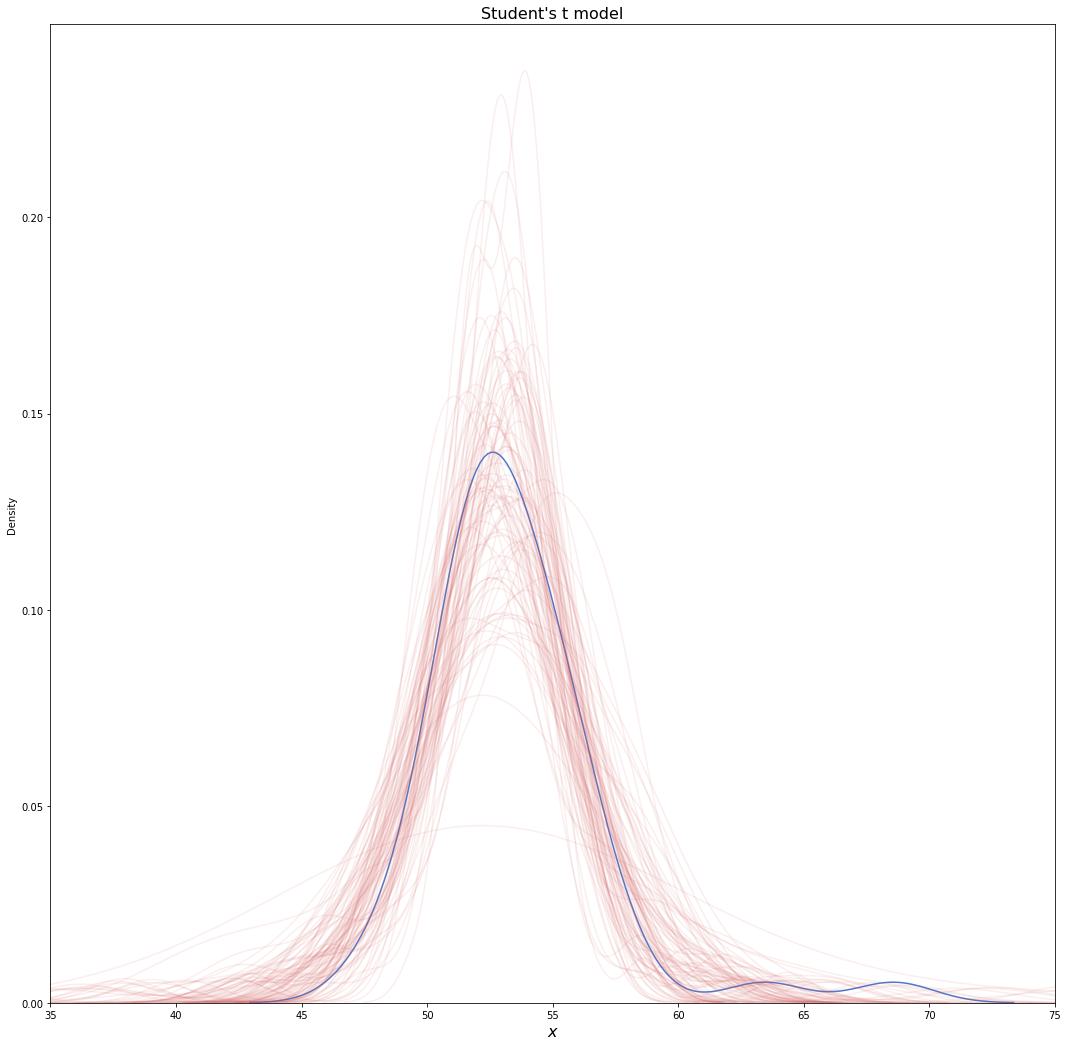

In [14]:

y_pred = pm.sampling.sample_posterior_predictive(
    chain_t, 100, model_t, size=len(data))
plt.figure(figsize=(18, 18))
sns.kdeplot(data, c='b')

for i in y_pred['y']:
    dataset = pd.DataFrame({'Column1': i[:, 0], 'Column2': i[:, 1]})
    sns.kdeplot(dataset.Column1, color='r', alpha=0.1)
    # sns.kdeplot(dataset.Column2, color='g', alpha=0.1)
plt.xlim(35, 75)
plt.title("Student's t model", fontsize=16)
plt.xlabel('$x$', fontsize=16)


In [15]:
# Tips example

tips = sns.load_dataset('tips')
tips.tail()

,total_bill,tip,sex,smoker,day,time,size
239,29.03,5.92,Male,No,Sat,Dinner,3
240,27.18,2.00,Female,Yes,Sat,Dinner,2
241,22.67,2.00,Male,Yes,Sat,Dinner,2
242,17.82,1.75,Male,No,Sat,Dinner,2
243,18.78,3.00,Female,No,Thur,Dinner,2


<AxesSubplot:xlabel='day', ylabel='tip'>

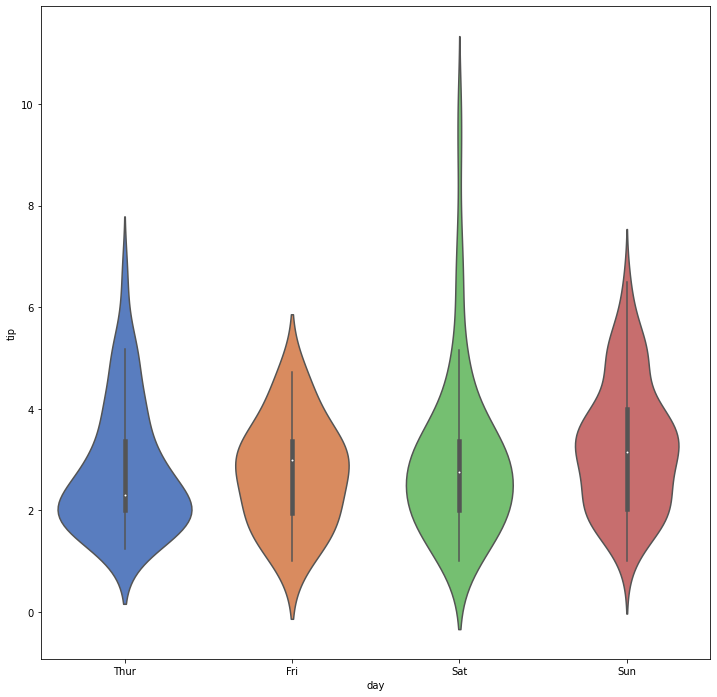

In [16]:
plt.figure(figsize=(12, 12))
sns.violinplot(x='day', y='tip', data=tips)

In [17]:
y = tips['tip'].values
x = pd.Categorical(tips['day']).codes
# x, y

In [18]:
with pm.Model() as comparing_groups:
    means = pm.Normal('means', mu=0, sd=10, shape=len(set(x)))
    sds = pm.HalfNormal('sds', sd=10, shape=len(set(x)))

    y = pm.Normal('y', mu=means[x], sd=sds[x], observed=y)

    trace_cg = pm.sample(5000)


e:\Code\Algorithmic-Trading\env\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  import sys
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sds, means]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 22 seconds.


Got error No model on context stack. trying to find log_likelihood in translation.
e:\Code\Algorithmic-Trading\env\lib\site-packages\arviz\data\io_pymc3_3x.py:102: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
Got error No model on context stack. trying to find log_likelihood in translation.


array([[<AxesSubplot:title={'center':'means'}>,
        <AxesSubplot:title={'center':'means'}>],
       [<AxesSubplot:title={'center':'sds'}>,
        <AxesSubplot:title={'center':'sds'}>]], dtype=object)

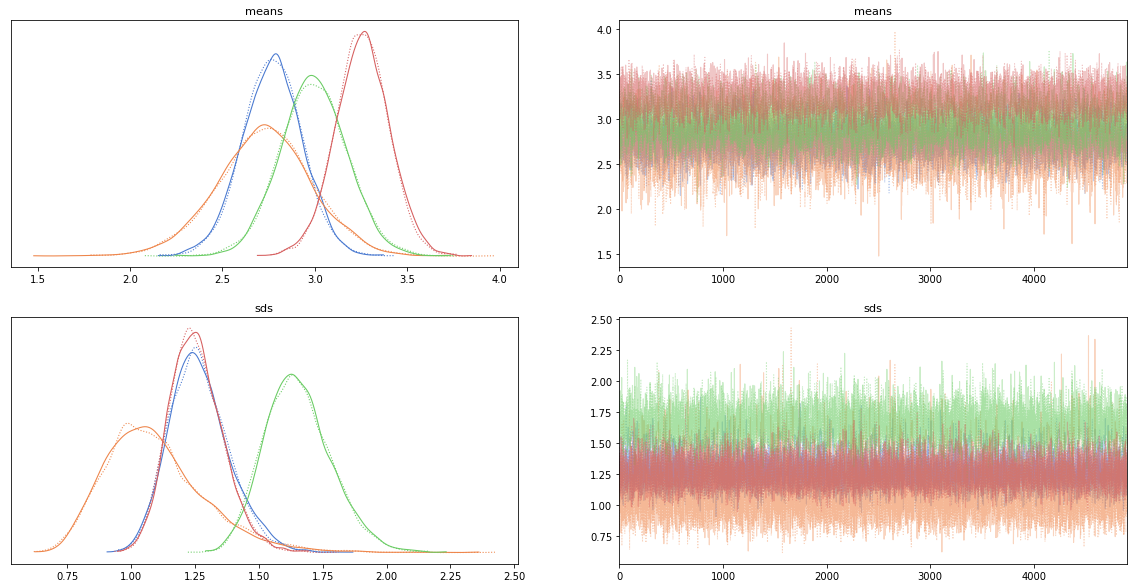

In [19]:
chain_cg = trace_cg[100::]
pm.plot_trace(chain_cg, figsize=(20, 10))

In [20]:
pm.summary(chain_cg)

Got error No model on context stack. trying to find log_likelihood in translation.
e:\Code\Algorithmic-Trading\env\lib\site-packages\arviz\data\io_pymc3_3x.py:102: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
means[0],2.77,0.16,2.47,3.07,2.00e-03,1.00e-03,11379.0,7492.0,1.0
means[1],2.73,0.26,2.23,3.20,3.00e-03,2.00e-03,8921.0,6481.0,1.0
means[2],2.99,0.18,2.65,3.32,2.00e-03,1.00e-03,11431.0,7705.0,1.0
means[3],3.26,0.14,2.99,3.54,1.00e-03,1.00e-03,14711.0,8205.0,1.0
sds[0],1.27,0.12,1.06,1.50,1.00e-03,1.00e-03,15141.0,7590.0,1.0
sds[1],1.10,0.20,0.76,1.48,2.00e-03,2.00e-03,10020.0,7406.0,1.0
sds[2],1.65,0.13,1.42,1.90,1.00e-03,1.00e-03,10921.0,7706.0,1.0
sds[3],1.25,0.10,1.06,1.45,1.00e-03,1.00e-03,14222.0,8251.0,1.0


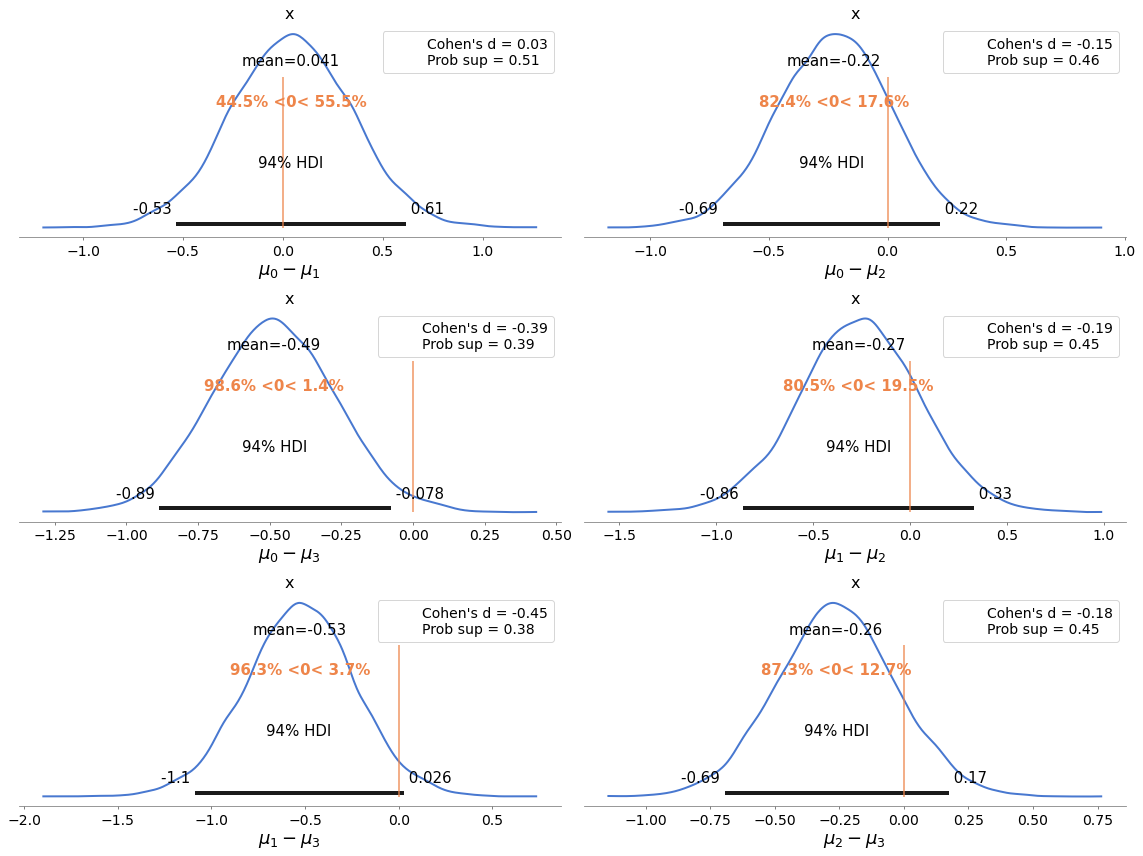

In [21]:
dist = stats.norm()

_, ax = plt.subplots(3, 2, figsize=(16, 12))

comparisons = [(i, j) for i in range(4) for j in range(i+1, 4)]
pos = [(k, l) for k in range(3) for l in (0, 1)]
# '''
for (i, j), (k, l) in zip(comparisons, pos):
    means_diff = chain_cg['means'][:, i]-chain_cg['means'][:, j]

    d_cohen = (
        means_diff / np.sqrt((chain_cg['sds'][:, i]**2 + chain_cg['sds'][:, j]**2) / 2)).mean()

    ps = dist.cdf(d_cohen/(2**0.5))

    pm.plot_posterior(means_diff, ref_val=0, ax=ax[k, l], kind='kde', lw=2)

    ax[k, l].plot(0, label="Cohen's d = {:.2f}\nProb sup = {:.2f}".format(
        d_cohen, ps), alpha=0)

    ax[k, l].set_xlabel('$\mu_{}-\mu_{}$'.format(i, j), fontsize=18)
    ax[k, l].legend(loc=0, fontsize=14)

plt.tight_layout()
# '''

In [22]:
# Hierarchical Models

N_samples = [30, 30, 30]
G_samples = [18, 18, 18]  # [13, 3, 3] [18, 3, 3]

group_idx = np.repeat(np.arange(len(N_samples)), N_samples)
# '''
data = []
for i in range(0, len(N_samples)):
    data.extend(np.repeat([1, 0], [G_samples[i], N_samples[i]-G_samples[i]]))
# '''

In [23]:
with pm.Model() as model_h:
    alpha = pm.HalfCauchy('alpha', beta=10)
    beta = pm.HalfCauchy('beta', beta=10)

    theta = pm.Beta('theta', alpha, beta, shape=len(N_samples))
    y = pm.Bernoulli('y', p=theta[group_idx], observed=data)

    trace_h = pm.sample(2000)


e:\Code\Algorithmic-Trading\env\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta, beta, alpha]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 21 seconds.
There were 108 divergences after tuning. Increase `target_accept` or reparameterize.
There were 163 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


Got error No model on context stack. trying to find log_likelihood in translation.
e:\Code\Algorithmic-Trading\env\lib\site-packages\arviz\data\io_pymc3_3x.py:102: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
Got error No model on context stack. trying to find log_likelihood in translation.


array([[<AxesSubplot:title={'center':'alpha'}>,
        <AxesSubplot:title={'center':'alpha'}>],
       [<AxesSubplot:title={'center':'beta'}>,
        <AxesSubplot:title={'center':'beta'}>],
       [<AxesSubplot:title={'center':'theta'}>,
        <AxesSubplot:title={'center':'theta'}>]], dtype=object)

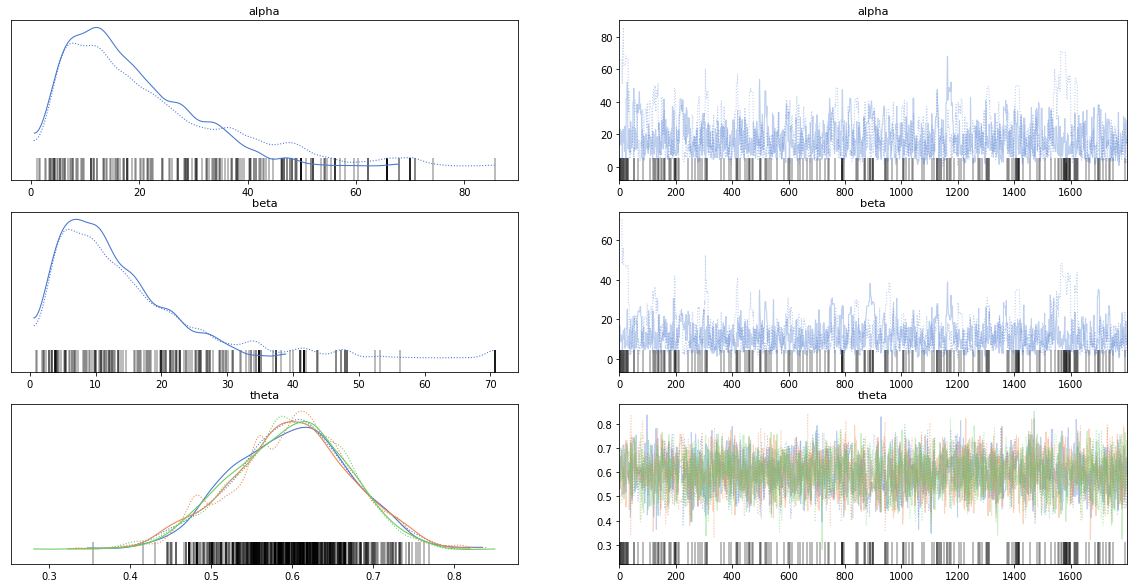

In [24]:
chain_h = trace_h[200:]
pm.plot_trace(chain_h, figsize=(20, 10))

In [25]:
pm.summary(chain_h) # Highest Density Interval: hdi_97

Got error No model on context stack. trying to find log_likelihood in translation.
e:\Code\Algorithmic-Trading\env\lib\site-packages\arviz\data\io_pymc3_3x.py:102: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,19.50,13.13,1.10,42.94,9.68e-01,8.19e-01,287.0,133.0,1.01
beta,13.23,9.21,1.35,29.30,6.87e-01,5.60e-01,298.0,149.0,1.01
theta[0],0.60,0.07,0.46,0.73,2.00e-03,1.00e-03,1248.0,1190.0,1.00
theta[1],0.60,0.07,0.46,0.74,2.00e-03,1.00e-03,1311.0,1679.0,1.00
theta[2],0.60,0.07,0.47,0.73,2.00e-03,1.00e-03,1228.0,1451.0,1.00


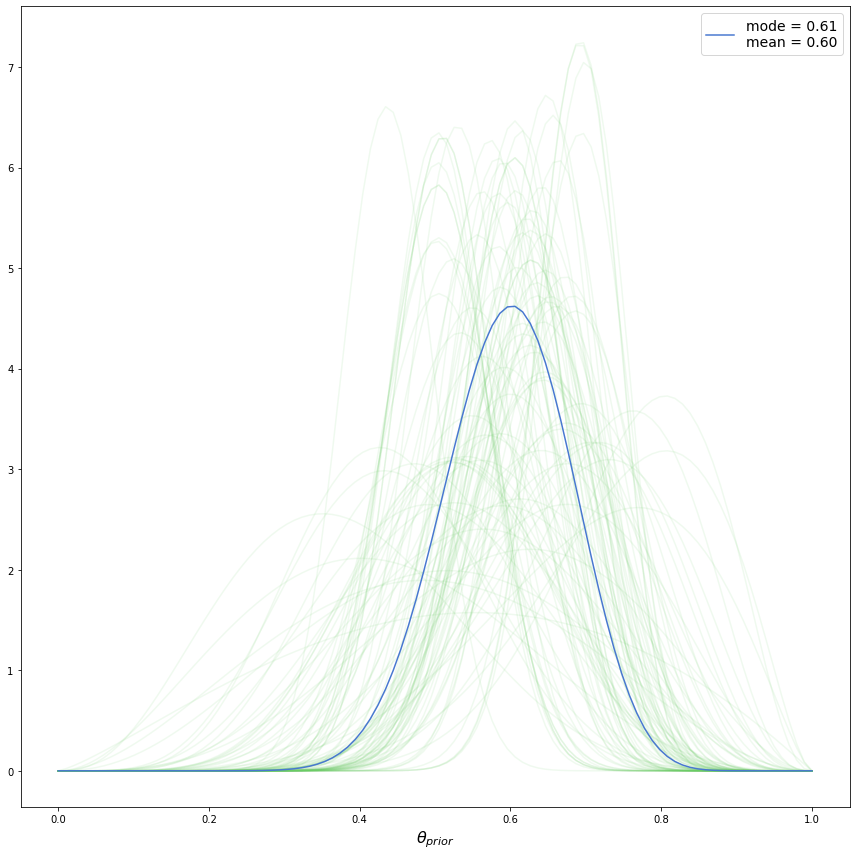

In [26]:
# Shrinkage

x = np.linspace(0, 1, 100)
plt.figure(figsize=(12, 12))

# estimated prior looks like
for i in np.random.randint(0, len(chain_h), size=100):
    pdf = stats.beta(chain_h['alpha'][i], chain_h['beta'][i]).pdf(x)
    plt.plot(x, pdf,  'g', alpha=0.1)

dist = stats.beta(chain_h['alpha'].mean(), chain_h['beta'].mean())
pdf = dist.pdf(x)

mode = x[np.argmax(pdf)]
mean = dist.moment(1)

plt.plot(x, pdf, label='mode = {:.2f}\nmean = {:.2f}'.format(mode, mean))

plt.legend(fontsize=14)
plt.xlabel('$\\theta_{prior}$', fontsize=16)
plt.tight_layout()